###### Its a file meant to compare the results of the hypertuned models obtained using stratified train test split and k fold cross validation with the hypertuned models obtained using k fold cross validation on the entire dataset.

# Importing Header and SoilPrep

In [1]:
import import_ipynb 
from Header import *

importing Jupyter notebook from Header.ipynb


In [2]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb


## Loading Data and MetaData

In [3]:
import import_ipynb
from LoadDataMetaData import *

importing Jupyter notebook from LoadDataMetaData.ipynb


In [4]:
import os
os.system('say "your Meta Tree started building"')
import time

In [5]:
# prepare_spec = ['none', 'fod2', 'continuum', 'log']
# prepare_target = ['none', 'minmax']

def find_X(p, n):
    if p == 'fod':
        X = fod_sampled[n]
    elif p == 'cr':
        X = sampled_cr[n]
    elif p == 'log':
        X = sampled_log[n]
    elif p == 'none':
        X = sampled_spec[n]
    elif p == 'fod_cr':
        X = fod_cr[n]
    else:
        X = fod_log[n]
    return X

def find_spec(p, n):
    if n == 0:
        spec = find_X(p, 100)            
    else:
        spec = find_X(p,n)
    return spec    


def find_y(t):
    i = target_names.index(t) 
    y = T[i]
    return y
        
        

## Recording Hypertuning Parameters

In [6]:
from sklearn.metrics import make_scorer, r2_score

model ={}
param_grid ={}
model['mult'] = LinearRegression()
param_grid['mult'] = { 'fit_intercept': [True, False] }

model['ridge'] = KernelRidge()
param_grid['ridge']={'alpha': [ 0.00001,0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, \
                               0.005,  0.01, 0.05, 0.1, 0.5, 1]}

model['plsr'] = PLSRegression()
param_grid['plsr']={'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


model['cubist'] = Cubist(random_state = 42)  
param_grid['cubist'] = { 
    'n_committees': [1, 5, 10, 15, 20, 25, 30], 
    'n_rules': [10, 20, 30, 40, 50]
}
                        

model['gbrt'] = GradientBoostingRegressor(random_state = 42)
param_grid['gbrt'] = {
    'n_estimators': [30,40,50],        # Number of boosting stages to be used
    'learning_rate': [0.01, 0.1],     # Step size shrinkage used in updating weights
    'max_depth': [3, 4, 5]                # Maximum depth of individual trees
#     'min_samples_split': [2, 3],        # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2],         # Minimum number of samples required to be at a leaf node
}

model['svr'] = SVR()
param_grid['svr'] = {
    'C': [0.1, 1, 10],              # Regularization parameter
    'kernel': ['linear', 'rbf'],   # Kernel function
    'gamma': [0.01, 0.1, 1],      # Kernel coefficient (only for 'rbf' kernel)
}


### Finding Hypertuned Parameters

In [7]:
# def find_core_model_param_on (m, t, p, tp, n):
#     Model = model[m]
#     X = find_spec(p,n,m)
#     y = find_y(t, tp)
    
#     row, col = X.shape

#     scorer = make_scorer(mean_squared_error, greater_is_better=False)
#     cv = RepeatedKFold(n_splits=row, n_repeats=1, random_state=3)
        
#     grid_search = GridSearchCV(Model, param_grid=param_grid[m], cv=cv,\
#                                 scoring= scorer, refit=True, verbose=1, error_score='raise', n_jobs=-1)
#     grid_search.fit(X,y)
    
#     return (grid_search.best_params_)

def find_tuned_param_on (X_train, y_train, m):
    Model = model[m]
    X = X_train
    y = y_train
    
    row, col = X.shape

    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=3)
        
    grid_search = GridSearchCV(Model, param_grid=param_grid[m], cv=cv,\
                                scoring= scorer, refit=True, verbose=1, error_score='raise', n_jobs=-1)
    grid_search.fit(X,y)
    
    return (grid_search.best_params_)
    

### Creating Hypertuned Models

In [8]:
def create_core_model_on (m, BP):
    if m == 'mult':
        Model = LinearRegression()
        
    elif m == 'ridge':
        Model =  KernelRidge(alpha = BP['alpha'])
        
    elif m == 'plsr':
        Model = PLSRegression(n_components = BP['n_components'])
        
    elif m == 'cubist':
        Model =  Cubist( n_committees = BP['n_committees'], n_rules = BP['n_rules'], \
                         random_state = 42) 
    
    elif m == 'gbrt':
        Model = GradientBoostingRegressor(n_estimators = BP['n_estimators'], learning_rate = BP['learning_rate'], \
                                          max_depth = BP['max_depth'],  random_state = 42)
    elif m == 'svr':
        Model = SVR(C = BP['C'], kernel = BP['kernel'], gamma = BP['gamma'])
        
    return Model    
            

## Building HMtree and BPtree

In [9]:
#ml_methods = ['mult', 'ridge', 'plsr', 'svr', 'cubist', 'gbrt']

In [10]:
def L1_y_pred (spectra, target, method, bp):
    m = method
    (r,c) = spectra.shape
    
    Y_test = target.copy()
    Y_pred = target.copy()
    #print('r:', r)
    for i in range (0, r): 
        #print('i: ', i)
        full_spec = spectra.copy()
        X_train = full_spec.drop(full_spec.index[i], axis=0)
        X_test = full_spec.iloc[[i],:].copy()
        full_tar = target.copy()
        y_train = full_tar.drop(full_tar.index[i], axis=0)
        y_test = full_tar.iloc[i].copy()        
        #---- Model Creation, fitting, and predictions--------
        Model = create_core_model_on (m, bp)
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test)
        Y_pred.iloc[i] = y_pred
        
    return Y_pred      

In [11]:
def best_split (X,y,tst_siz, num_bins):
    ymin = y.min()
    ymax = y.max()
    trn_siz = 1-tst_siz

    Y_binned, bin_edges = pd.qcut(y, q=num_bins, labels=False, retbins=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= tst_siz, stratify=Y_binned, random_state=0)
    rand_st = 0
    bin_train = np.histogram(y_train, bins = num_bins, range = (ymin,ymax), density=False)
    bin_test = np.histogram(y_test, bins = num_bins, range = (ymin,ymax), density=False)
    error = abs((bin_train[0])/trn_siz - (bin_test[0])/tst_siz)
    cum_error = error.sum()
    min_err= cum_error
    
    for i in np.arange(1,999,1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= tst_siz, stratify=Y_binned, random_state=i)
        bin_train = np.histogram(y_train, bins = num_bins, range = (ymin,ymax), density=False)
        bin_test = np.histogram(y_test, bins = num_bins, range = (ymin,ymax), density=False)
        error = abs((bin_train[0])/trn_siz - (bin_test[0])/tst_siz)
        cum_error = error.sum()
        if cum_error < min_err:
            min_err = cum_error
            rand_st = i
            #print(i)

    return (rand_st, min_err)

In [12]:
spec = find_spec('none',50)  
y = T[0]

num_bins = 10
tst_siz = 0.25

rand_st, min_err = best_split (spec,y,tst_siz, num_bins)
rand_st, min_err

(817, 26.666666666666668)

Training set: (700, 50), (700,)
Test set: (234, 50), (234,)


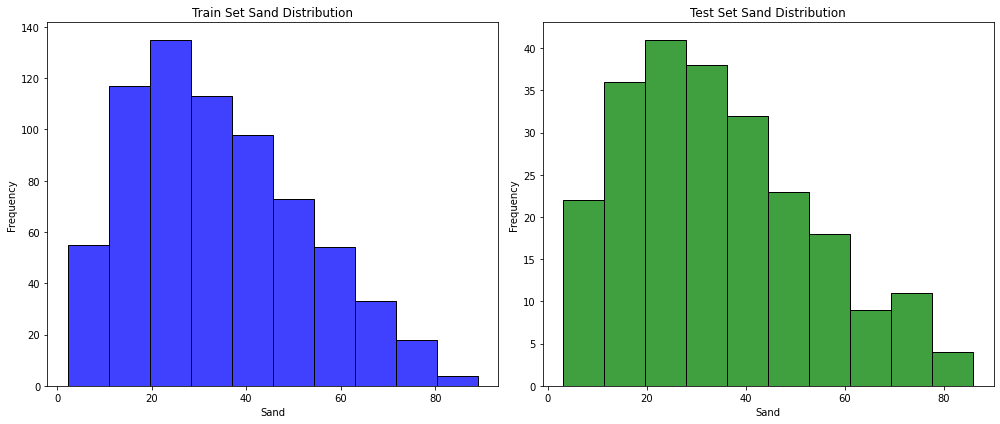

In [13]:
Y_binned, bin_edges = pd.qcut(y, q=num_bins, labels=False, retbins=True)
X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, stratify=Y_binned, random_state=rand_st)

print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

# Plot histograms of the train and test sets
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=num_bins, kde=False, color='blue', edgecolor='black')
plt.title('Train Set Sand Distribution')
plt.xlabel('Sand')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(y_test, bins=num_bins, kde=False, color='green', edgecolor='black')
plt.title('Test Set Sand Distribution')
plt.xlabel('Sand')
plt.ylabel('Frequency')

plt.tight_layout()

In [14]:
#halt here

In [15]:
def build_HMtree_on (target, method_name):
    
    tree ={}
    
    start = time.time()
    m = method_name
    t = target
    
    #print('tree for: '+ m +' ------> running on: ' + t)
    
    for tp in prepare_target:
        tree[tp] ={}        
        for p in prepare_spec:
            tree[tp][p] ={}            
            for n in nbands_sampling:
                tree[tp][p][n] ={}
                Y = tree[tp][p][n]
                                           
                #------ setting spec to appropriate (sampled) spectra----                
                spec = find_spec(p, n)                
                                        
                #---- target selection and normalization ---
                y = find_y(t)
                                
                #---- performing stratified split to obtain 25% data for hypertuning ----------------------
                X_loose, X_keep, y_loose, y_keep = train_test_split(spec, y, test_size= tst_siz,stratify=Y_binned, random_state=rand_st)
                            
                #----- hypertuning parameter, model creation, fitting and prediction ----                
                
                #bp = find_tuned_param_on (X_train, y_train, m)
                bp = find_tuned_param_on (X_keep, y_keep, m)
                
                Y['bp'] = bp
                print('Hypertuned on Target: '+ t+ '----> Method: '+ m + '--->  SpecProc: ' +p+ ' ---> n_band: ', n)
                Model = create_core_model_on (m, bp)
                
                #---- performing train-test split for evaluation and plots----------------------
                X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz,stratify=Y_binned, random_state=rand_st)
                
                Model.fit(X_train, y_train)
                
                y_pred = Model.predict(X_test)
                yhat_pred = Model.predict(X_train)
                    
                #----- Data for Model accuracy and plotting -----------
                Y['X_test'] = X_test                
                Y['y_test'] = y_test
                Y['y_testP'] = y_pred
                
                Y['X_train'] = X_train
                Y['y_train'] = y_train
                Y['y_trainP'] = yhat_pred
                    
                Y['iqrp_test'] = find_iqrp(y_pred, y_test)
                Y['r2_test'] = find_r2(y_pred, y_test)
                Y['rpd_test'] = find_rpd(y_pred, y_test)                 
                
                Y['r2_train'] = find_r2(yhat_pred, y_train)
                
                #------- L1 out prediction on test data -----------------
                L1y_pred = L1_y_pred (spec, y, m, bp)
                Y['L1y_testP'] = L1y_pred
                Y['L1y_test'] = y
                 
                
                Y['L1iqrp_test'] = find_iqrp(L1y_pred, y)
                Y['L1r2_test'] = find_r2(L1y_pred, y)
                Y['L1rpd_test'] = find_rpd(L1y_pred, y) 
                
                                                                         
    end = time.time()                            
    os.system('say "your hyper tuned meta tree finished for one more method"')                            

    print('End time - Start time =', (end-start)) 
    
    return tree.copy()

In [16]:
def build_HMtree_for (target_name):
    tree ={}
    
    start = time.time()
    t = target_name
    for m in ml_methods:
        print('tree for: '+ t +' ------> running on: ' + m)
        tree[m] = build_HMtree_on (t, m)
        os.system('say "your meta tree finished for one more method"')
        
    end = time.time()                            
                                
    print('End time - Start time =', (end-start))     
    return tree.copy()

In [17]:
#build_HMtree_for('TOC')

def BuildStore_HMtree_for (target_name, hmtree):
    
    start = time.time()
    t = target_name
    hmtree[t] ={}
    
    for m in ml_methods:
        print('tree for: '+ t +' ------> running on: ' + m)
        hmtree[t][m] = build_HMtree_on (t, m)
        os.system('say "your meta tree finished for one more method"')
        with open (f'HMtree_{m}.pickle', 'wb') as file:
            pickle.dump(hmtree[t][m], file)
        
    end = time.time()                            
                                
    print('End time - Start time =', (end-start))     
    return

In [18]:
def best_score_on (HMtree, target, method, scorer):
    t=target
    m= method
    
    best_score = -1
    #best_n_comp = 'NA'
    
    
    for tp in prepare_target:
        for p in prepare_spec:
            for n in nbands_sampling:
                Y = HMtree[t][m][tp][p][n]
                #r2_train = Y['r2_train']
                #r2_test = Y['r2_test']
                #L1r2_test = Y['L1r2_test']
                 
                    
                if scorer == 'iqrp':
                    cur_score = Y['iqrp_test']
                elif scorer == 'L1iqrp':
                    cur_score = Y['L1iqrp_test']
                elif scorer == 'r2':
                    cur_score = Y['r2_test'] 
                else:
                    cur_score = Y['L1r2_test']  
                    
                if cur_score > best_score:
                    best_score = cur_score
                    best_tp = tp
                    best_n = n
                    best_p = p
                            
    param_list = [scorer, np.round(best_score,2), 'Spec:', best_p, 'bands:', best_n]                                 
    return (param_list)          

In [19]:
def best_score_for (HMtree, target, scorer):
    
    for method in ml_methods:
        param_list= best_score_on (HMtree, target, method, scorer)
        print('For:'+target+'->', param_list, ':'+method)
     
    return

In [20]:
# with open ('HMtree.pickle', 'rb') as file:
#     HMtree = pickle.load(file)
 

## Creating different branches of Mtree (for separate methods)

In [21]:
#HMtree = {}


In [22]:
#BuildStore_HMtree_for('Sand', HMtree)

In [23]:
HMtree = {}
HMtree['Sand'] = {}

with open ('HMtree_plsr.pickle', 'rb') as file:
    HMtree['Sand']['plsr'] = pickle.load(file)    
with open ('HMtree_svr.pickle', 'rb') as file:
    HMtree['Sand']['svr'] = pickle.load(file)    
with open ('HMtree_ridge.pickle', 'rb') as file:
    HMtree['Sand']['ridge'] = pickle.load(file)
    
    

In [24]:
# HMtree['TOC']['cubist'] = build_HMtree_on('TOC', 'cubist')

# with open ('HMtree_cubist.pickle', 'wb') as file:
#             pickle.dump(HMtree['TOC']['cubist'], file)


In [25]:
# HMtree['TOC']['gbrt'] = build_HMtree_on('TOC', 'gbrt')

# with open ('HMtree_gbrt.pickle', 'wb') as file:
#             pickle.dump(HMtree['TOC']['gbrt'], file)

In [26]:
# with open ('HMtree.pickle', 'wb') as file:
#     pickle.dump(HMtree, file)
        

In [27]:
#Plotting Model Accuracy (ipywidgets)
def plot_model_acc (method, target, spec_preprocessing, n_bands):
    
    m = method
    t = target
    
    i = target_names.index(target)    
    
    p = spec_preprocessing
    n = n_bands
    tp = 'none'
    
    Y = HMtree[t][m][tp][p][n]
    
    y_test = Y['y_test']
    y_pred = Y['y_testP']
    L1y_pred = Y['L1y_testP']
    L1y_test = Y['L1y_test']

    y_train = Y['y_train']
    yhat_pred = Y['y_trainP']
    

    
    if m == 'plsr':
        y_pred = y_pred[:,0]
        #L1y_pred = L1y_pred[:,0]

    
    iqrp_test = Y['iqrp_test']
    r2_test = Y['r2_test']
    rpd_test = Y['rpd_test']

    #iqrp_train = find_iqrp(yhat_pred, y_train)
    r2_train = Y['r2_train']
    #rpd_train = find_rpd(yhat_pred, y_train)
    
    L1iqrp_test = Y['L1iqrp_test']
    L1r2_test = Y['L1r2_test']
    L1rpd_test = Y['L1rpd_test']
    
    y_tp = pd.DataFrame({'actual':y_test.values, 'predic': y_pred})
    z = np.polyfit(y_test, y_pred, 1)

    yhat_tp = pd.DataFrame({'actual':y_train.values, 'predic': yhat_pred})
    zhat = np.polyfit(y_train, yhat_pred, 1)
    
    L1y_tp = pd.DataFrame({'actual':L1y_test.values, 'predic': L1y_pred})
    L1z = np.polyfit(L1y_test, L1y_pred, 1)
    
    fig, axes = plt.subplots(2,2, figsize=(18,16))
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    y_tp.plot.scatter(ax= axes[0][0], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[0][0].plot(y_test, np.polyval(z, y_test),  c='blue', linewidth=1)
    axes[0][0].plot(y_test, y_test, color='green', linewidth=1)
    axes[0][0].tick_params(axis='both', labelsize=10)
    axes[0][0].text(0.05, 0.95, target_names[i]+' (Test Score)', transform=axes[0][0].transAxes, fontsize = 20, color = clr[i])
    axes[0][0].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_test), transform=axes[0][0].transAxes, fontsize = 16)
    axes[0][0].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_test), transform=axes[0][0].transAxes, fontsize = 16)
    axes[0][0].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_test,3)), transform=axes[0][0].transAxes, fontsize = 16)
    axes[0][0].text(0.95, 0.15, 'Method: '+method, transform=axes[0][0].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    
    L1y_tp.plot.scatter(ax= axes[0][1], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[0][1].plot(L1y_test, np.polyval(L1z, L1y_test),  c='blue', linewidth=1)
    axes[0][1].plot(L1y_test, L1y_test, color='green', linewidth=1)
    axes[0][1].tick_params(axis='both', labelsize=10)
    axes[0][1].text(0.05, 0.95, target_names[i]+' (L1-out Score)', transform=axes[0][1].transAxes, fontsize = 20, color = clr[i])
    axes[0][1].text(0.05, 0.90, 'IQRP ={:.2f}'.format(L1iqrp_test), transform=axes[0][1].transAxes, fontsize = 16)
    axes[0][1].text(0.05, 0.85, 'RPD ={:.2f}'.format(L1rpd_test), transform=axes[0][1].transAxes, fontsize = 16)
    axes[0][1].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(L1r2_test,3)), transform=axes[0][1].transAxes, fontsize = 16)
    axes[0][1].text(0.95, 0.15, 'Method: '+method, transform=axes[0][1].transAxes, 
                    horizontalalignment='right', fontsize = 20)

    
     #------------------------ Ploting R2 Vs N_bands-----------------------------------
    
    #--- data for creating n_bands vs r2 scores plot -------------------------------
    
    pY = HMtree[t][m]['none'][p]        
    X = nbands_sampling
    
    Yr2 = []
    L1Yr2 = []
    
    for j in X:
        Yr2.append(pY[j]['r2_test'])
        L1Yr2.append(pY[j]['L1r2_test'])  
   
    j = 0
    while j < len(Yr2): 
        if Yr2[j] <= 0:
            Yr2[j] = 0
        if L1Yr2[j] <= 0:
            L1Yr2[j] = 0
        j = j + 1
 
    #------------------------------ STEM PLOT ---- for accuracy Vs n_bands ---------------------------------- 
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    yhat_tp.plot.scatter(ax= axes[1][0], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[1][0].plot(y_train, np.polyval(zhat, y_train),  c='blue', linewidth=1)
    axes[1][0].plot(y_train, y_train, color='green', linewidth=1)
    axes[1][0].tick_params(axis='both', labelsize=10)
    axes[1][0].text(0.05, 0.95, target_names[i]+' (Train Score)', transform=axes[1][0].transAxes, fontsize = 20, color = clr[i])
    #axes[1][0].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_train), transform=axes[1][0].transAxes, fontsize = 16)
    #axes[1][0].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_train), transform=axes[1][0].transAxes, fontsize = 16)
    axes[1][0].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_train,3)), transform=axes[1][0].transAxes, fontsize = 16)
    axes[1][0].text(0.95, 0.15, 'Method: '+method, transform=axes[1][0].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    
    
    axes[1][1].stem(X,L1Yr2)
    axes[1][1].tick_params(axis='both', labelsize=10)
    axes[1][1].text(0.00, 1.01,  target_names[i], transform=axes[1][1].transAxes,fontsize = 20, color = clr[i])
    axes[1][1].text(0.99, 1.01, 'Spec_prep: '+ p, transform=axes[1][1].transAxes, horizontalalignment='right', fontsize = 16)
    axes[1][1].text(0.17, 1.01, '(L1-out)', transform=axes[1][1].transAxes, horizontalalignment='left', fontsize = 16)
    axes[1][1].text(0.60, -0.1, 'n_bands', transform=axes[1][1].transAxes, horizontalalignment='right', fontsize = 16)
    axes[1][1].text(-0.1, 0.5, 'R2 Scores', horizontalalignment='left', verticalalignment='center', \
                rotation='vertical', transform=axes[1][1].transAxes, fontsize = 16)
        
   
    return    

In [28]:
ml_methods = ['ridge', 'plsr', 'svr']

#ml_methods = ['plsr', 'svr', 'ridge', 'cubist','gbrt']

In [29]:
best_score_for (HMtree, 'Sand', 'r2')


For:Sand-> ['r2', 0.77, 'Spec:', 'log', 'bands:', 80] :ridge
For:Sand-> ['r2', 0.74, 'Spec:', 'fod_log', 'bands:', 90] :plsr
For:Sand-> ['r2', 0.47, 'Spec:', 'none', 'bands:', 0] :svr


In [30]:
best_score_for (HMtree, 'Sand', 'L1r2')

For:Sand-> ['L1r2', 0.75, 'Spec:', 'log', 'bands:', 90] :ridge
For:Sand-> ['L1r2', 0.7, 'Spec:', 'fod_log', 'bands:', 90] :plsr
For:Sand-> ['L1r2', 0.5, 'Spec:', 'none', 'bands:', 0] :svr


In [31]:
#best_score_for (HMtree, 'Silt', 'r2')

In [32]:
#best_score_for (HMtree, 'Silt', 'L1r2')

In [33]:
#best_score_for (HMtree, 'Clay', 'r2')

In [34]:
#best_score_for (HMtree, 'Clay', 'L1r2')

In [35]:
#best_score_for (HMtree, 'TOC', 'r2')-

In [36]:
#best_score_for (HMtree, 'TOC', 'L1r2')

In [37]:
#best_score_for (HMtree, 'CaCO3', 'r2')

In [38]:
#best_score_for (HMtree, 'CaCO3', 'L1r2')

## Plotting Model Accuracy (ipywidgets)

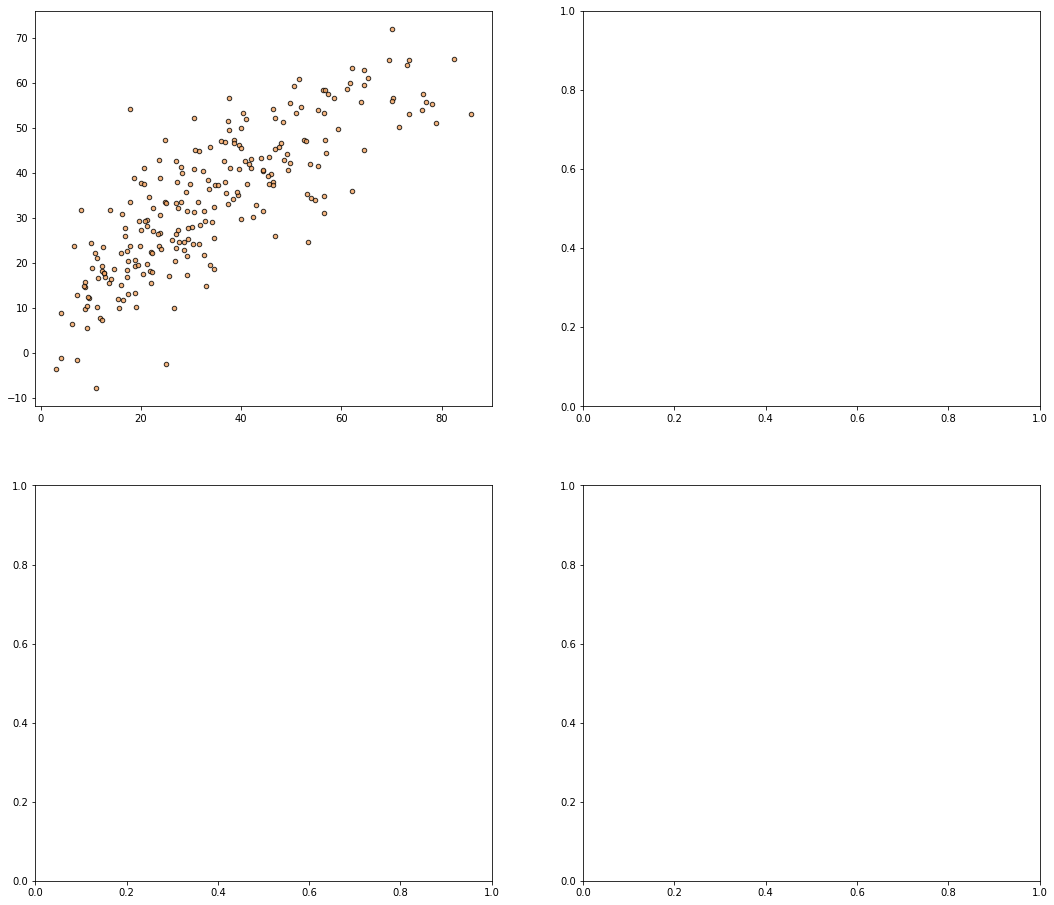

interactive(children=(Dropdown(description='method', options=('ridge', 'plsr', 'svr'), value='ridge'), Dropdow…

<function __main__.plot_model_acc(method, target, spec_preprocessing, n_bands)>

In [39]:
ipywidgets.interact( plot_model_acc, target = target_names, method = ml_methods, \
                    spec_preprocessing = prepare_spec,  \
                    target_preprocessing = prepare_target, n_bands = nbands_sampling )